# Methodology using Logistic Regression

## Intro steps

###Mount Colab to drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

###Set file paths, make sure these are the newest files

In [2]:
# path1 = "/content/drive/My Drive/DAT 490/Datafiles/Crashes.csv"
# path2 = "/content/drive/My Drive/DAT 490/Datafiles/People.csv"
# path3 = "/content/drive/My Drive/DAT 490/Datafiles/Vehicles.csv"

#local paths

path1 = "C:\\Users\\User\\Documents\\School\\ASU\\DAT_490\\Datafiles\\Crashes.csv"
path2 = "C:\\Users\\User\\Documents\\School\\ASU\\DAT_490\\Datafiles\\People.csv"
path3 = "C:\\Users\\User\\Documents\\School\\ASU\\DAT_490\\Datafiles\\Vehicles.csv"

### Import libraries

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

### Load Datasets

In [4]:
Crashes = pd.read_csv(path1)
People = pd.read_csv(path2)
Vehicles = pd.read_csv(path3)

In [5]:
print(f"Crashes dataset shape: {Crashes.shape}")
print("Crashes columns:")
print(Crashes.columns)

print(f"People dataset shape: {People.shape}")
print("\nPeople columns:")
print(People.columns)

print(f"Vehicles dataset shape: {Vehicles.shape}")
print("\nVehicles columns:")
print(Vehicles.columns)

Crashes dataset shape: (859966, 42)
Crashes columns:
Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')
People dataset shape

## Data processing

### Merge the datasets

In [6]:
crashes_people_merged = pd.merge(Crashes, People, on=['CRASH_RECORD_ID'], how='left')


In [7]:
full_merged_data = pd.merge(crashes_people_merged, Vehicles, on=['CRASH_RECORD_ID'],how='left')

Check datasets

In [8]:
# Check for discrepancies between CRASH_DATE_x (Crashes) and CRASH_DATE_y (People)
date_comparison = crashes_people_merged[['CRASH_RECORD_ID', 'CRASH_DATE_x', 'CRASH_DATE_y']].copy()
date_comparison['Date_Match'] = date_comparison['CRASH_DATE_x'] == date_comparison['CRASH_DATE_y']

# Look at rows where the dates don’t match between Crashes and People datasets
date_mismatch_crashes_people = date_comparison[date_comparison['Date_Match'] == False]

print("Number of mismatches between Crashes and People on CRASH_DATE: ", len(date_mismatch_crashes_people))
print(date_mismatch_crashes_people.head())

# Now compare the merged crashes_people dataset with Vehicles on CRASH_DATE
date_comparison_full = full_merged_data[['CRASH_RECORD_ID', 'CRASH_DATE_x', 'CRASH_DATE_y', 'CRASH_DATE']].copy()
date_comparison_full['Date_Match_Crashes_Vehicles'] = date_comparison_full['CRASH_DATE_x'] == date_comparison_full['CRASH_DATE']
date_comparison_full['Date_Match_People_Vehicles'] = date_comparison_full['CRASH_DATE_y'] == date_comparison_full['CRASH_DATE']

# Look at rows where the dates don’t match with Vehicles
date_mismatch_full = date_comparison_full[(date_comparison_full['Date_Match_Crashes_Vehicles'] == False) | 
                                          (date_comparison_full['Date_Match_People_Vehicles'] == False)]

print("Number of mismatches between Crashes/People and Vehicles on CRASH_DATE: ", len(date_mismatch_full))
print(date_mismatch_full.head())


Number of mismatches between Crashes and People on CRASH_DATE:  154526
                                      CRASH_RECORD_ID         CRASH_DATE_x  \
0   5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...  2023-07-29 14:45:00   
43  0a29b0429c4d0e851fb03dfe40f88defd8bdc352a1ee8c...  2023-07-31 20:00:00   
48  bde92bfca22985fc0b0354b01d1eb8b71e312ff6b171c1...  2023-08-20 07:00:00   
70  ae8f3969d7eb77c01f8b0a4aef6b5f8287bf58759639f4...  2023-09-08 13:15:00   
76  a5148efd1daca1a75626ac46aa374cbedc7dc7c39188e6...  2023-08-01 01:00:00   

   CRASH_DATE_y  Date_Match  
0           NaN       False  
43          NaN       False  
48          NaN       False  
70          NaN       False  
76          NaN       False  
Number of mismatches between Crashes/People and Vehicles on CRASH_DATE:  2465347
                                     CRASH_RECORD_ID         CRASH_DATE_x  \
0  5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...  2023-07-29 14:45:00   
1  5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f

In [9]:
print(f"Merged dataset shape: {full_merged_data.shape}")
print(full_merged_data.columns)
print(full_merged_data.shape)

Merged dataset shape: (2465347, 79)
Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE_x',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH_x',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'PERSON_ID', 'PERSON_TYPE',
       'VEHICLE_ID', 'CRASH_

### Create INJURY_CLASSIFICATION target variable

In [10]:
# Create INJURY_CLASSIFICATION column based on existing injury data
def classify_injury(row):
    if row['INJURIES_FATAL'] > 0:
        return 4  # Fatal
    elif row['INJURIES_INCAPACITATING'] > 0:
        return 2  # Incapacitating
    elif row['INJURIES_NON_INCAPACITATING'] > 0:
        return 1  # Non-incapacitating
    elif row['INJURIES_REPORTED_NOT_EVIDENT'] > 0:
        return 3  # Reported, not evident
    elif row['INJURIES_NO_INDICATION'] > 0:
        return 0  # No indication of injury
    else:
        return -1  # Unknown or not classified
        
# Apply this to the dataset
full_merged_data.loc[:, 'INJURY_CLASSIFICATION'] = full_merged_data.apply(classify_injury, axis=1)

### Check for missing data

In [11]:
missing_data_summary = full_merged_data.isnull().sum()
print("Missing Data Summary:")
print(missing_data_summary[missing_data_summary > 0])

Missing Data Summary:
PERSON_ID              189642
PERSON_TYPE            189642
VEHICLE_ID             189642
CRASH_DATE_y           189642
SEAT_NO                189642
CITY                   189642
STATE                  189642
ZIPCODE                189642
SEX                    189642
AGE                    189642
AIRBAG_DEPLOYED        189642
EJECTION               189642
DRIVER_ACTION          189642
DRIVER_VISION          189642
PHYSICAL_CONDITION     189642
BAC_RESULT VALUE       189642
CELL_PHONE_USE         189642
CRASH_YEAR             189642
CRASH_MONTH_y          189642
CRASH_DAY              189642
BAC_RESULT_ENCODED     189642
CRASH_UNIT_ID          135642
CRASH_DATE             135642
UNIT_NO                135642
UNIT_TYPE              135642
MAKE                   135642
MODEL                  135642
LIC_PLATE_STATE        135642
VEHICLE_YEAR           135642
VEHICLE_DEFECT         135642
VEHICLE_TYPE           135642
VEHICLE_USE            135642
TRAVEL_DIRECTION  

Show percentage of missing data

In [12]:
total_entries_per_column = full_merged_data.shape[0]  # Total number of rows is the same for all columns since it's a full merged dataset

missing_data_percentage = (missing_data_summary / total_entries_per_column) * 100  # Calculate percentage of missing data per column

missing_data_info = pd.DataFrame({
    'Missing Values': missing_data_summary,
    'Total Entries': total_entries_per_column,
    'Percentage Missing': missing_data_percentage
})

missing_data_info = missing_data_info[missing_data_info['Missing Values'] > 0]

print("Missing Data Summary (With Percentages):")
print(missing_data_info[['Missing Values', 'Percentage Missing']].sort_values(by='Percentage Missing', ascending=False))

Missing Data Summary (With Percentages):
                     Missing Values  Percentage Missing
PERSON_ID                    189642            7.692305
EJECTION                     189642            7.692305
BAC_RESULT_ENCODED           189642            7.692305
CRASH_DAY                    189642            7.692305
PERSON_TYPE                  189642            7.692305
CRASH_YEAR                   189642            7.692305
CELL_PHONE_USE               189642            7.692305
BAC_RESULT VALUE             189642            7.692305
PHYSICAL_CONDITION           189642            7.692305
DRIVER_VISION                189642            7.692305
DRIVER_ACTION                189642            7.692305
CRASH_MONTH_y                189642            7.692305
AIRBAG_DEPLOYED              189642            7.692305
SEX                          189642            7.692305
ZIPCODE                      189642            7.692305
STATE                        189642            7.692305
CITY   

### Dropping NaNs
Decided to drop the NaNs because there were not that many values overall we only lose 7%-5% of the colum data and ~12% of overall data still leaving us with 2,167,470 entries and 77 features.

In [13]:
full_merged_data_cleaned = full_merged_data.dropna()

In [14]:
missing_data_summary_after_drop = full_merged_data_cleaned.isnull().sum()
print("Missing Data Summary:")
print(missing_data_summary_after_drop[missing_data_summary_after_drop > 0])

Missing Data Summary:
Series([], dtype: int64)


In [15]:
full_merged_data_cleaned.shape

(2167847, 79)

In [16]:
percent_removed = (2464980-2167470)/2464980
percent_removed

0.12069469123481733

In [17]:
full_merged_data_cleaned.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE_x',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH_x',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'PERSON_ID', 'PERSON_TYPE',
       'VEHICLE_ID', 'CRASH_DATE_y', 'SEAT_NO', 'CITY', 'STATE',

## Create model

### Relevant features for predicting accident severity
Added target variable, to keep it simple for our first iteration looking at a binar of if the injuries are more fatal based on the time of day

In [18]:
features = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 
            'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ROADWAY_SURFACE_COND', 
            'ROAD_DEFECT', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 
            'PERSON_TYPE', 'SEX', 'AIRBAG_DEPLOYED', 'EJECTION', 'DRIVER_ACTION', 
            'DRIVER_VISION', 'MAKE', 'MODEL', 'VEHICLE_TYPE', 'VEHICLE_USE', 
            'FIRST_CONTACT_POINT','LATITUDE', 'LONGITUDE', 'CRASH_HOUR',
            'POSTED_SPEED_LIMIT','FIRST_CRASH_TYPE','AGE',]

# Now, use this new column as your target
target = ['INJURY_CLASSIFICATION']

### Preprocessing pipeline
- OneHotEncoder will handle categorical features
- StandardScaler will standardize numerical features

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        # Standardize numerical features
        ('num', StandardScaler(), [
            'LANE_CNT', 'LATITUDE', 'LONGITUDE', 'CRASH_HOUR', 'POSTED_SPEED_LIMIT', 'AGE'
        ]),
        
        # One-hot encode categorical features
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [
            'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
            'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'DAMAGE',
            'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'PERSON_TYPE', 'SEX',
            'AIRBAG_DEPLOYED', 'EJECTION', 'DRIVER_ACTION', 'DRIVER_VISION',
            'MAKE', 'MODEL', 'VEHICLE_TYPE', 'VEHICLE_USE', 'FIRST_CONTACT_POINT', 'FIRST_CRASH_TYPE'
        ])
    ]
)

### Use a sample of the data to speed up training

In [20]:
full_merged_data_cleaned_sample = full_merged_data_cleaned.sample(frac=0.1, random_state=42)
X_sample = full_merged_data_cleaned_sample[features]
y_sample = full_merged_data_cleaned_sample[target]

### Split data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

### Create Pipelines with SMOTE for balanced data

In [22]:
# Convert y_train to a series
y_train = y_train.squeeze()
y_train = y_train.astype(int)
print(y_train.dtype)
print(y_train.unique())  # Check unique values to ensure they are discrete classes

int32
[0 3 1 2 4]


In [23]:
# Create individual pipelines
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
])


In [24]:
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [25]:
# Ensure y_test is a 1-D array
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test_array = y_test.values.ravel()
else:
    y_test_array = y_test.ravel()

In [26]:
# Convert y_test_array to integer type if necessary
y_test_array = y_test_array.astype(int)

### Train the logistic regression model

In [27]:
# Train and predict Logistic Regression
lr_pipeline.fit(X_train, y_train.values.ravel())
y_pred_lr = lr_pipeline.predict(X_test)

### Train the Random Forest model

In [28]:
rf_pipeline.fit(X_train, y_train.values.ravel())
y_pred_rf = rf_pipeline.predict(X_test)

### Combine the models using Voting Classifier

In [29]:
combined_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('voting', VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')),  # Use lbfgs solver for probability
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
        ],
        voting='soft'  # Soft voting for probability-based predictions
    ))
])

In [30]:
# Train and evaluate the combined model
combined_pipeline.fit(X_train, y_train.values.ravel())
# Predict probabilities with the combined model
y_pred_combined_proba = combined_pipeline.predict_proba(X_test)

# Predict the final class based on highest probability
y_pred_combined = np.argmax(y_pred_combined_proba, axis=1)

### Evaluate the combined model

In [31]:
# Evaluate the model
conf_matrix = confusion_matrix(y_test_array, y_pred_combined)
class_report = classification_report(y_test_array, y_pred_combined)
accuracy_combined = accuracy_score(y_test_array, y_pred_combined)
print(f"Combined Accuracy: {accuracy_combined:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Combined Accuracy: 0.78
Confusion Matrix:
[[47022  2199   595   746   547]
 [ 3612  2699   640   231   408]
 [  610   445   360    42   136]
 [ 3062   743   200   448   167]
 [   22    21    30     1    50]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     51109
           1       0.44      0.36      0.39      7590
           2       0.20      0.23      0.21      1593
           3       0.31      0.10      0.15      4620
           4       0.04      0.40      0.07       124

    accuracy                           0.78     65036
   macro avg       0.37      0.40      0.34     65036
weighted avg       0.76      0.78      0.76     65036



## Generate images

### Confusion matrix for ensamble

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

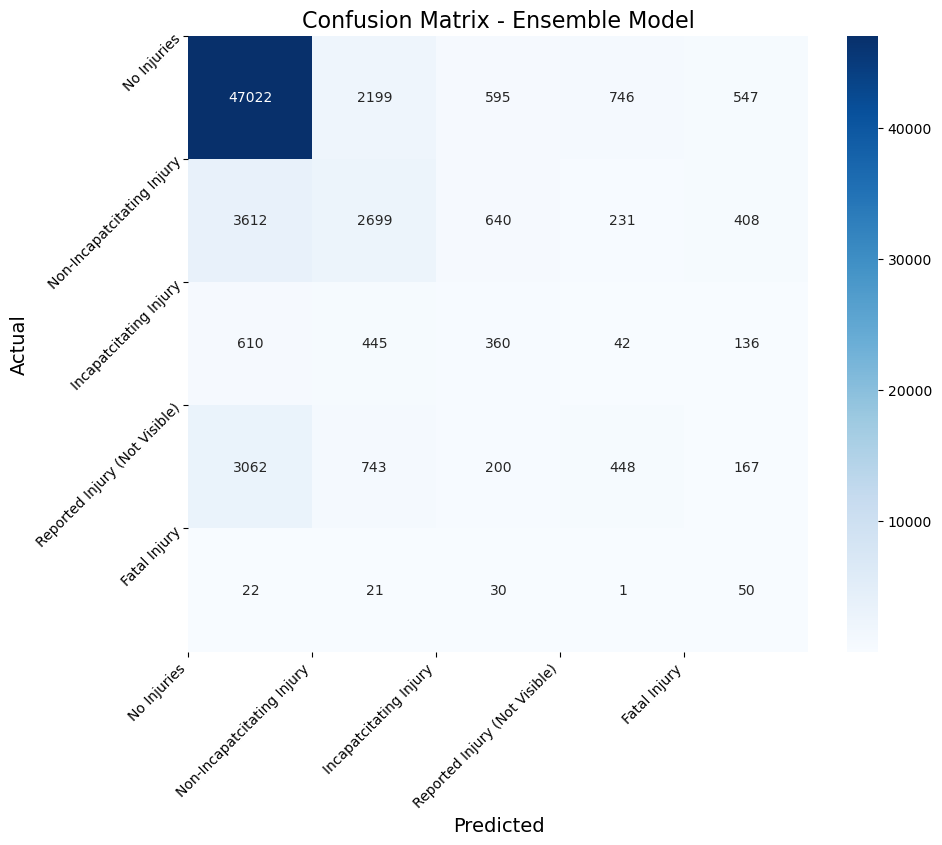

In [33]:
conf_matrix = confusion_matrix(y_test_array, y_pred_combined)

injury_labels = [
    'No Injuries',          # 0
    'Non-Incapatcitating Injury',     # 1
    'Incapatcitating Injury',         # 2
    'Reported Injury (Not Visible)',   # 3
    'Fatal Injury'                   # 4
]


# Find the position of the highest value in the confusion matrix
max_value = np.max(conf_matrix)
max_idx = np.unravel_index(np.argmax(conf_matrix, axis=None), conf_matrix.shape)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True)

# Add labels and title
plt.title('Confusion Matrix - Ensemble Model', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Set custom axis labels
plt.xticks(ticks=range(len(injury_labels)), labels=injury_labels, rotation=45, ha='right')
plt.yticks(ticks=range(len(injury_labels)), labels=injury_labels, rotation=45, rotation_mode='anchor')

# Save the plot as a PNG file
plt.savefig('highlighted_confusion_matrix_ensemble.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Before and after data balancing

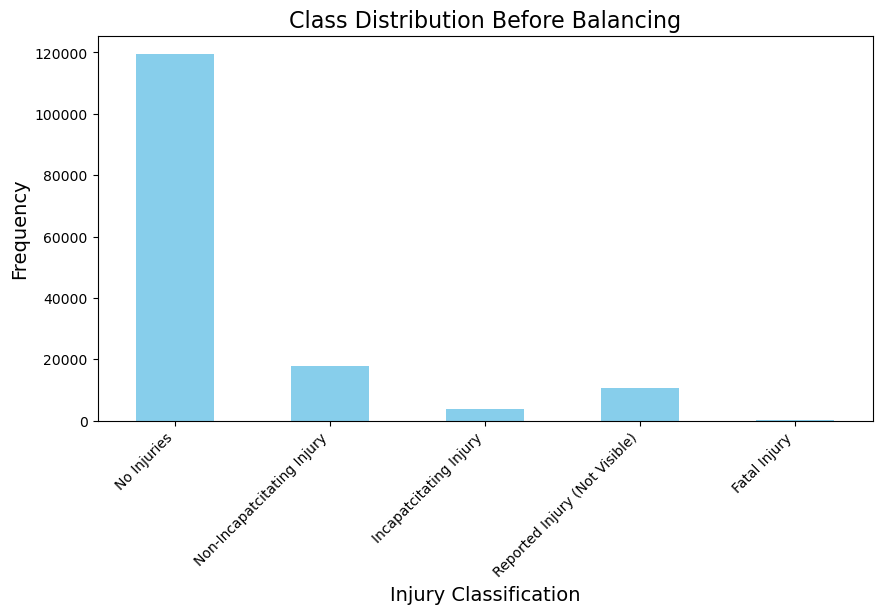

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

injury_labels = [
    'No Injuries',          # 0
    'Non-Incapatcitating Injury',     # 1
    'Incapatcitating Injury',         # 2
    'Reported Injury (Not Visible)',   # 3
    'Fatal Injury'                   # 4
]

# Before resampling
plt.figure(figsize=(10, 5))
y_train.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before Balancing', fontsize=16)
plt.xlabel('Injury Classification', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(ticks=range(len(injury_labels)), labels=injury_labels, rotation=45, ha='right')
plt.savefig('class_distribution_before_balancing.png', dpi=300, bbox_inches='tight')
plt.show()


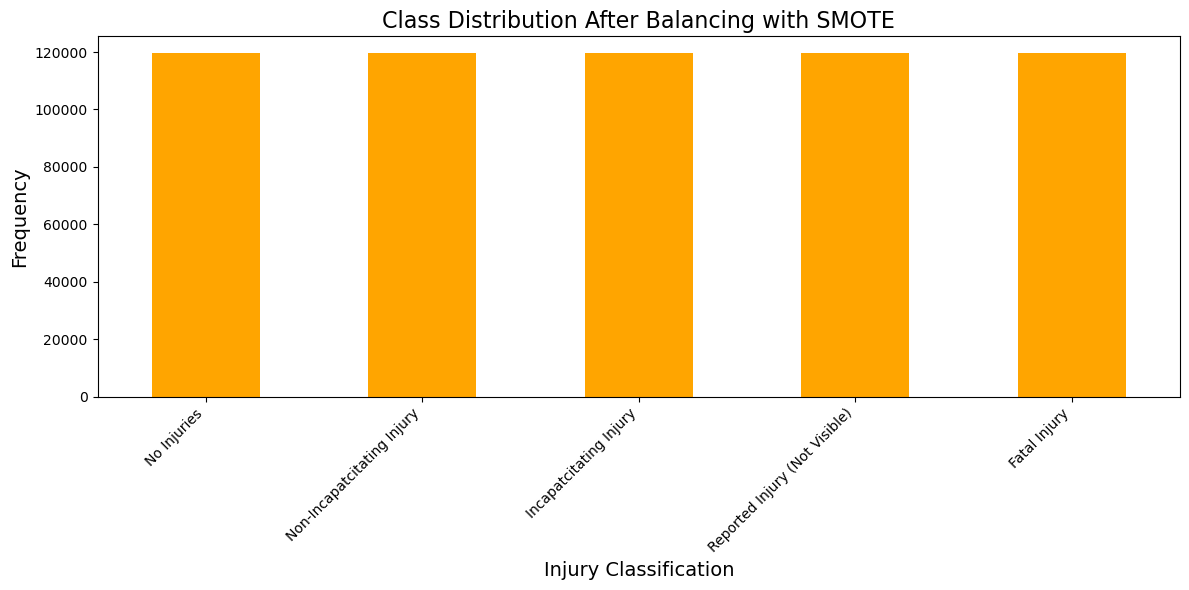

In [35]:
from imblearn.over_sampling import SMOTE

injury_labels = [
    'No Injuries',          # 0
    'Non-Incapatcitating Injury',     # 1
    'Incapatcitating Injury',         # 2
    'Reported Injury (Not Visible)',   # 3
    'Fatal Injury'                   # 4
]
# Apply the preprocessor to X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# Apply SMOTE to get resampled X and y
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

# After resampling
plt.figure(figsize=(12, 6))
counts_after = pd.Series(y_resampled).value_counts().sort_index()
counts_after.plot(kind='bar', color='orange')

plt.title('Class Distribution After Balancing with SMOTE', fontsize=16)
plt.xlabel('Injury Classification', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Set custom x-axis labels
plt.xticks(ticks=range(len(injury_labels)), labels=injury_labels, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('class_distribution_after_balancing.png', dpi=300, bbox_inches='tight')
plt.show()

### ROC Curves (Receiver Operating Characteristic Curves)

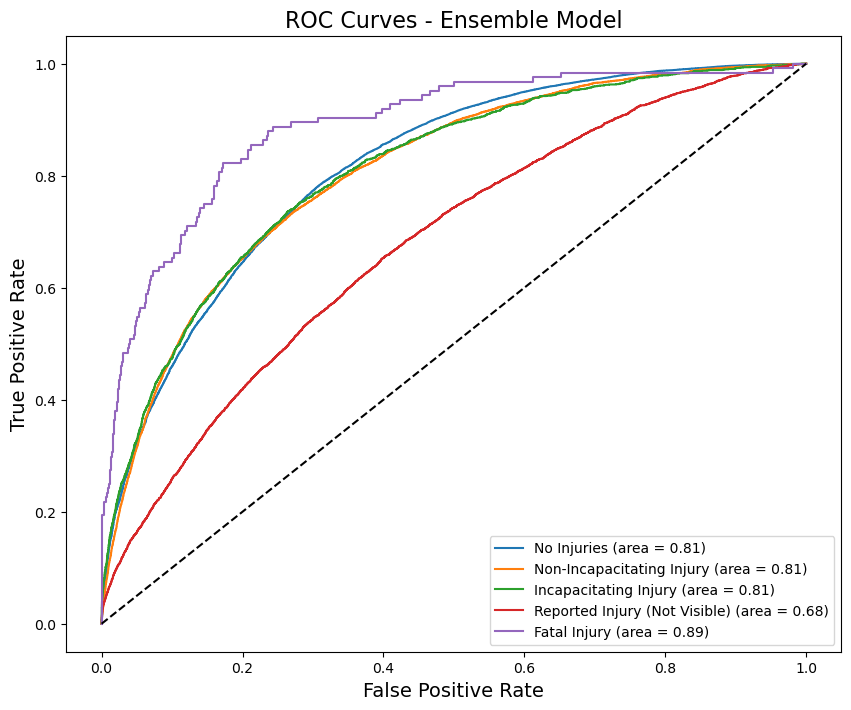

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Define the injury class labels
injury_labels = [
    'No Injuries',          # 0
    'Non-Incapacitating Injury',     # 1
    'Incapacitating Injury',         # 2
    'Reported Injury (Not Visible)',   # 3
    'Fatal Injury'                   # 4
]

# Define the classes for binarization (assuming these are the injury classification labels)
classes = [0, 1, 2, 3, 4]  # Adjust these based on your injury classes

# Apply the preprocessor to the test data
X_test_transformed = preprocessor.transform(X_test)

# Binarize the output for ROC curve calculation
y_test_binarized = label_binarize(y_test_array, classes=classes)
# Predict probabilities for Voting Classifier
y_score_combined = combined_pipeline.named_steps['voting'].predict_proba(X_test_transformed)

# Compute ROC curve and AUC for Combined Voting Classifier
fpr_combined = dict()
tpr_combined = dict()
roc_auc_combined = dict()
for i in range(len(classes)):
    fpr_combined[i], tpr_combined[i], _ = roc_curve(y_test_binarized[:, i], y_score_combined[:, i])
    roc_auc_combined[i] = auc(fpr_combined[i], tpr_combined[i])

# Plot ROC curves for Combined Voting Classifier
plt.figure(figsize=(10, 8))
for i in range(len(injury_labels)):
    plt.plot(fpr_combined[i], tpr_combined[i], label=f'{injury_labels[i]} (area = {roc_auc_combined[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves - Ensemble Model', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.savefig('roc_curves_ensemble_model.png', dpi=300, bbox_inches='tight')
plt.show()


### Precision-Recall Curves

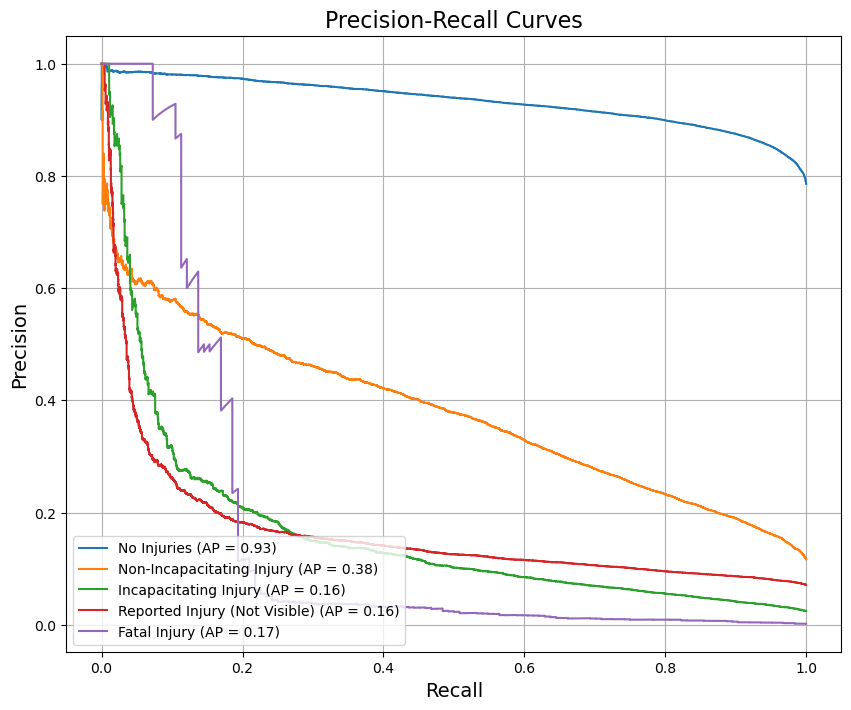

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Define your injury labels
injury_labels = [
    'No Injuries',          # 0
    'Non-Incapacitating Injury',     # 1
    'Incapacitating Injury',         # 2
    'Reported Injury (Not Visible)',   # 3
    'Fatal Injury'                   # 4
]

# Binarize the output
y_test_binarized = label_binarize(y_test_array, classes=[0, 1, 2, 3, 4])

# Get predicted probabilities for the ensemble model
y_score_combined = combined_pipeline.named_steps['voting'].predict_proba(X_test_transformed)

# Initialize dictionaries to store precision, recall, and average precision
precision = dict()
recall = dict()
average_precision = dict()

# Loop through each class to compute precision-recall values
for i in range(len(injury_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score_combined[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score_combined[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for i in range(len(injury_labels)):
    plt.plot(recall[i], precision[i], label=f'{injury_labels[i]} (AP = {average_precision[i]:0.2f})')

plt.title('Precision-Recall Curves', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig('precision_recall_curves_ensemble_model.png', dpi=300, bbox_inches='tight')
plt.show()


### NIR Bar Graph

In [38]:
most_frequent_class_count = 51171
total_samples = 65025
NIR = most_frequent_class_count / total_samples

print(f"No-Information Rate (NIR): {NIR:.2%}") 


No-Information Rate (NIR): 78.69%


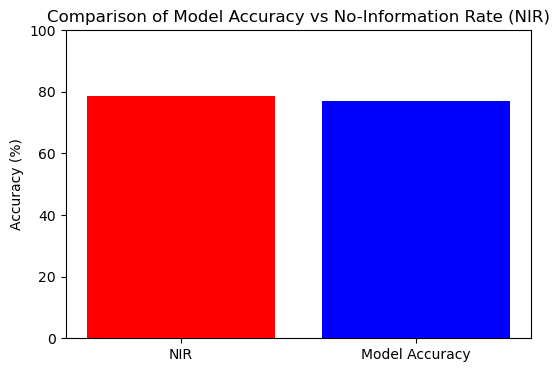

In [39]:
import matplotlib.pyplot as plt

# Example values
NIR = NIR*100
model_accuracy = 77  # Your model's accuracy

# Bar chart data
labels = ['NIR', 'Model Accuracy']
values = [NIR, model_accuracy]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['red', 'blue'])
plt.title('Comparison of Model Accuracy vs No-Information Rate (NIR)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.savefig('nir_vs_model_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


Debugging